# Fitting $E_K$ and $\bar{g}$ to a full set of traces
Here, I'm attempting to use the kinetics that I've determined previously (in Kv14-extended and Kv14x-with-round3) to fit the basic conductance parameters to a complete set of traces (activation and tail currents) from a single cell.

In [1]:
%load_ext autoreload
%autoreload 1

%aimport analysis_helpers
%aimport Kv14

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import analysis_helpers as ah
import time

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
a = Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (36,37,None,39))

In [3]:
a.fit()

analysis_helpers.py:123: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:123: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


Trace 8 truncated fast tau 12.39594796487387


In [4]:
print a.params

{'C': 176.3268809966603, 'I_K': <function <lambda> at 0x7fdd082a40c8>, 'g_leak': 0.001947927406144797, 'I_leak': <function <lambda> at 0x7fdd087bf578>, 'g_K': 0.051908565542574094, 'E_K': -80.00196452234002, 'E_leak': -7.3570960636895, 'g_A': 0.08408435862263253}


I posit an initial set of one-component ($ps$) and two-component ($p$) parameters based on the fitting results from the pre-round3 naïve algorithms to act as a starting point for this exploration:

In [5]:
ps = [-80., 0.09]

In [6]:
p = [-80., 0.022, 0.092]

Firstly, I want to do what I think is the best possible fit: Using the true voltage to integrate the two-component model.

In [7]:
# rec preparation

# tmax = Kv14.rec_limits[1] - Kv14.rec_limits[0]
tmax = 5000
tblank = Kv14.rec_limits[0] - Kv14.rec_step_t0

# Assume 10 seconds of holding at the median prepulse potential, starting from a half-activated state
Vhold = np.array([np.median(voltage[:Kv14.rec_step_t0]) for voltage in a.rec.voltage])
rec_hold_state = zip(*Kv14.state_at(10000, Vhold, (.5,.5,.5,.5)))

# Populate the two-component HH states over the requested period
rec_states = np.zeros((len(a.rec.voltage), tmax, 4))
for i, voltage, state in zip(range(len(a.rec.voltage)), a.rec.voltage, rec_hold_state):
    for t in range(tblank):
        V = voltage[Kv14.rec_step_t0 + t]
        state = Kv14.state_at(Kv14.tres, V, state)

    for t in range(tmax):
        V = voltage[Kv14.rec_limits[0] + t]
        state = Kv14.state_at(Kv14.tres, V, state)
        rec_states[i][t] = state

In [8]:
# prepare rec target, subtracting leak current with per-trace conductance
gleak = ah.get_gleak(a.rec, a.params['E_leak'], (0, Kv14.rec_step_t0))
Irec_target = np.array([
                        I[Kv14.rec_limits[0] : Kv14.rec_limits[0] + tmax]
   - a.params['I_leak'](V[Kv14.rec_limits[0] : Kv14.rec_limits[0] + tmax], g)
                        for I, V, g in zip(a.rec.current, a.rec.voltage, gleak)])

In [9]:
# rec2 preparation

# t2max = Kv14.rec2_limits[1] - a.rec2.tail_cut
t2max = 5000
t2blank = a.rec2.tail_cut - Kv14.rec2_limits[0]

Vhold2 = np.array([np.median(voltage[:Kv14.rec2_prepulse]) for voltage in a.rec2.voltage])
rec2_hold_state = zip(*Kv14.state_at(10000, Vhold2, (.5,.5,.5,.5)))

rec2_states = np.zeros((len(a.rec2.voltage), t2max, 4))
for i, voltage, state in zip(range(len(a.rec2.voltage)), a.rec2.voltage, rec2_hold_state):
    for t in range(Kv14.rec2_prepulse, Kv14.rec2_limits[0]):
        state = Kv14.state_at(Kv14.tres, voltage[t], state)

    for t in range(t2blank):
        V = voltage[Kv14.rec2_limits[0] + t]
        state = Kv14.state_at(Kv14.tres, V, state)

    for t in range(t2max):
        V = voltage[a.rec2.tail_cut + t]
        state = Kv14.state_at(Kv14.tres, V, state)
        rec2_states[i][t] = state

In [10]:
# rec2 target
gleak2 = ah.get_gleak(a.rec2, a.params['E_leak'], (0, Kv14.rec2_prepulse))
Irec2_target = np.array([
                         I[a.rec2.tail_cut : a.rec2.tail_cut + t2max]
    - a.params['I_leak'](V[a.rec2.tail_cut : a.rec2.tail_cut + t2max], g)
                         for I, V, g in zip(a.rec2.current, a.rec2.voltage, gleak2)])

In [11]:
def currents(p):
    '''
    Computes the current traces from non-kinetic parameters (EK, gslow, gfast) in p
    and precalculated states rec_states and rec2_states
    '''
    Irec = np.reshape([(voltage[Kv14.rec_limits[0] + t] - p[0]) * (p[1] * state[0]**4 * state[1]
                                                                 + p[2] * state[2]**4 * state[3])
                      for voltage, states in zip(a.rec.voltage, rec_states)
                      for t, state in enumerate(states)],
                     (len(a.rec.voltage), tmax))

    Irec2 = np.reshape([(voltage[a.rec2.tail_cut + t] - p[0]) * (p[1] * state[0]**4 * state[1]
                                                               + p[2] * state[2]**4 * state[3])
                       for voltage, states in zip(a.rec2.voltage, rec2_states)
                       for t, state in enumerate(states)],
                      (len(a.rec2.voltage), t2max))
    
    return (Irec, Irec2)

Let's just try the manually defined parameters to start with...

Text(0.5,0.98,'Two components, unfitted initial values, using achieved voltage')

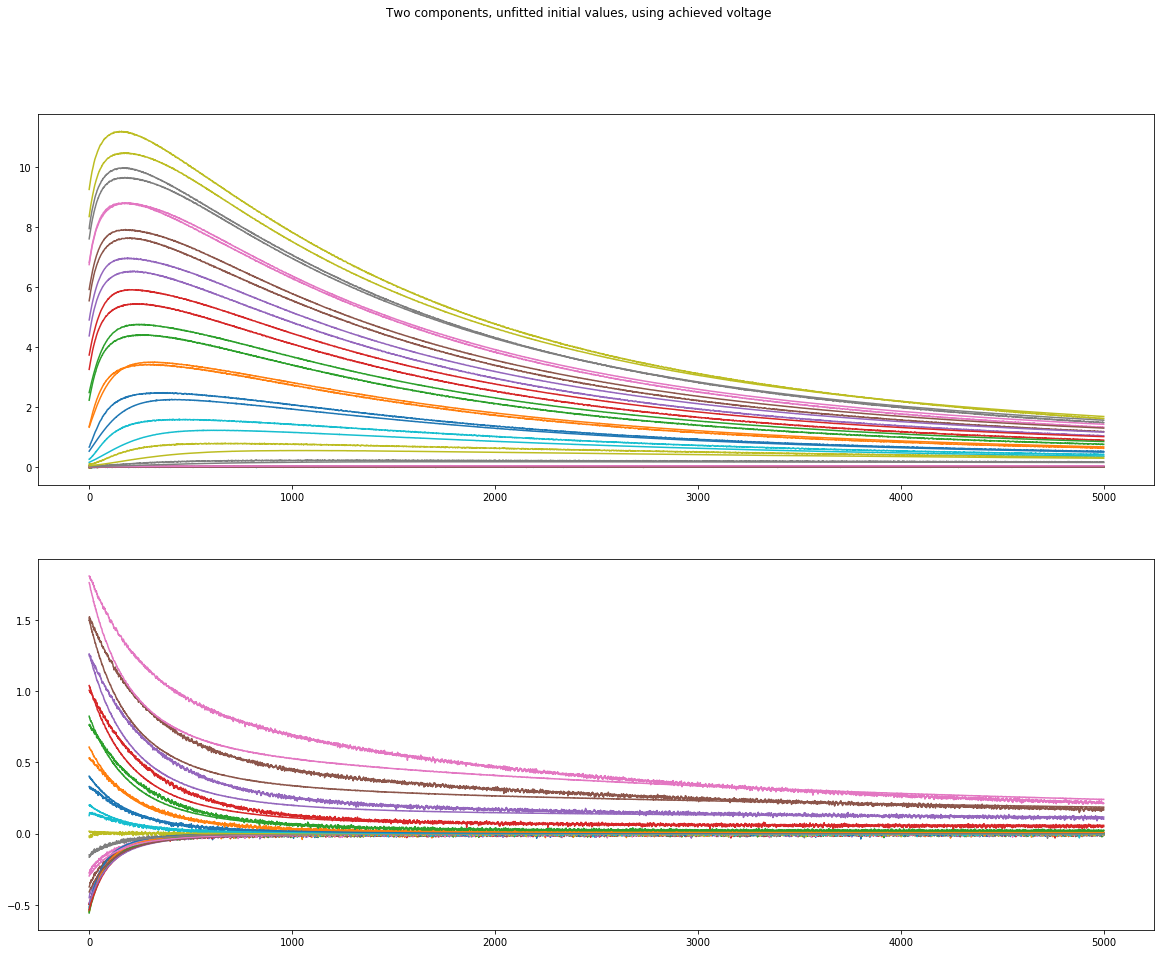

In [12]:
I1, I2 = currents(p)

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
for I in Irec_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I1:
    plt.plot(I)

plt.subplot(2,1,2)
for I in Irec2_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I2:
    plt.plot(I)
    
plt.suptitle("Two components, unfitted initial values, using achieved voltage")

Not too bad, but it could surely be improved upon. Let's do a least-squares fit!

In [13]:
def residuals(p, current_fn):
    Irec, Irec2 = current_fn(p)
    
    # compare to target
    Irec -= Irec_target
    Irec2 -= Irec2_target
    
    return np.concatenate((Irec.ravel(), Irec2.ravel()))

In [14]:
start = time.time()
ret = scipy.optimize.least_squares(residuals, p, args = (currents,), bounds = ([-100, 0, 0], [-50, 0.05, 0.15]))
print time.time() - start

7.84823799133


In [15]:
I1, I2 = currents(ret.x)

Text(0.5,0.98,'Two components, fitted using achieved voltage')

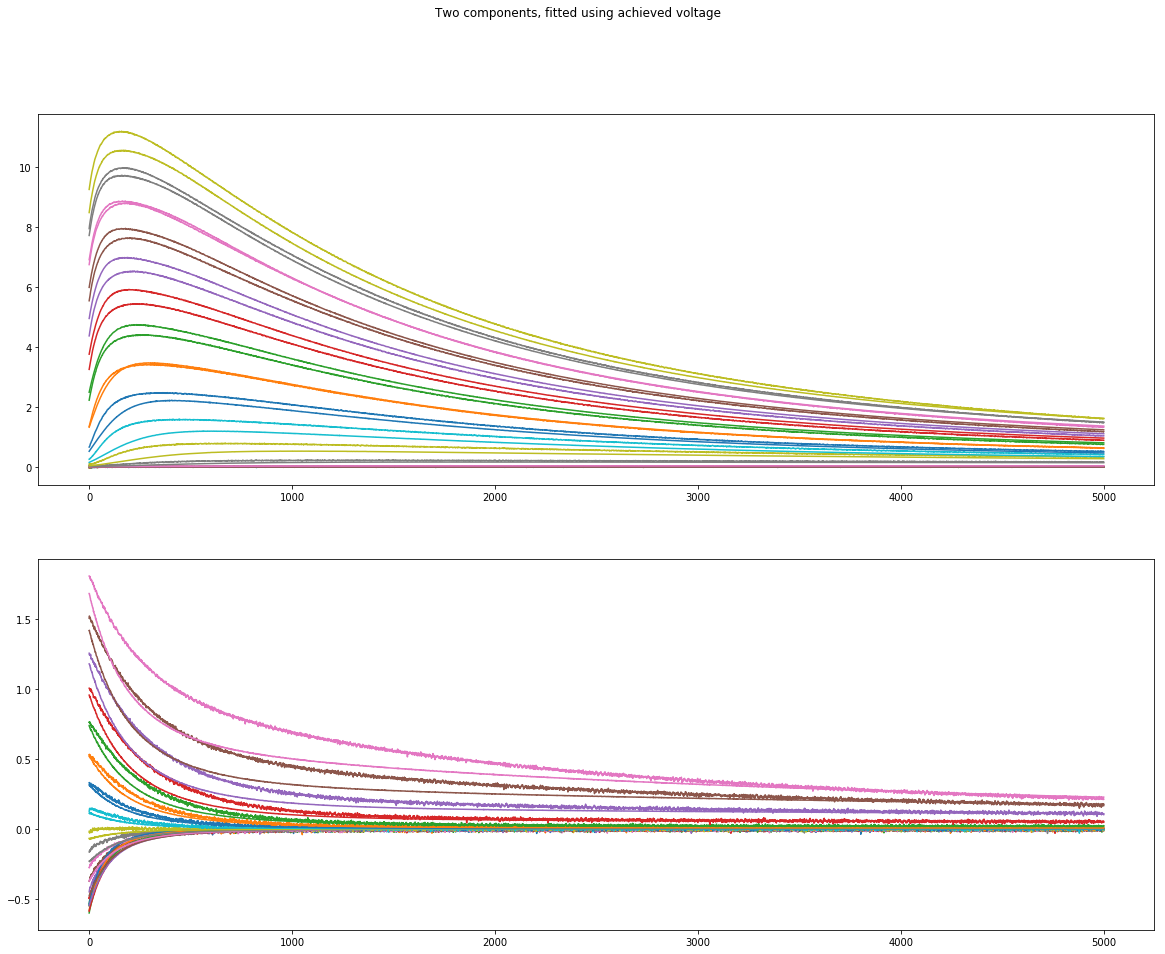

In [16]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
for I in Irec_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I1:
    plt.plot(I)

plt.subplot(2,1,2)
for I in Irec2_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I2:
    plt.plot(I)
    
plt.suptitle("Two components, fitted using achieved voltage")

In [17]:
print ret.x
print ret.cost

[-7.76856372e+01  2.08440141e-02  9.53116383e-02]
945.0671241332949


Hm. That could be a whole lot better. It looks like the initial kinetics really aren't being captured very well!

Next, just for comparison, let's see if using the median voltage, rather than the actual voltage trace, makes any difference. I'd expect this to work less well, but on the other hand, the kinetics were fit against median voltage, so it might work out differently...

In [18]:
Vrec = [np.median(voltage[Kv14.rec_limits[0] : Kv14.rec_limits[1]]) for voltage in a.rec.voltage]
states_medV = [Kv14.state_at((np.arange(tmax) + tblank)*Kv14.tres, V, state)
               for V, state in zip(Vrec, rec_hold_state)]

Vprep = [np.median(voltage[Kv14.rec2_prepulse : Kv14.rec2_limits[0]]) for voltage in a.rec2.voltage]
rec2_prep_state = [Kv14.state_at((Kv14.rec2_limits[0] - Kv14.rec2_prepulse)*Kv14.tres, V, state)
                for V, state in zip(Vprep, rec2_hold_state)]
Vrec2 = [np.median(voltage[a.rec2.tail_cut : Kv14.rec2_limits[1]]) for voltage in a.rec2.voltage]
states2_medV = [Kv14.state_at((np.arange(t2max) + t2blank)*Kv14.tres, V, state)
                for V, state in zip(Vrec2, rec2_prep_state)]

def currents_medV(p):
    Irec = np.array([(V - p[0]) * (p[1] * state[0]**4 * state[1]
                                 + p[2] * state[2]**4 * state[3]) for V, state in zip(Vrec, states_medV)])
    Irec2 = np.array([(V - p[0]) * (p[1] * state[0]**4 * state[1]
                                  + p[2] * state[2]**4 * state[3]) for V, state in zip(Vrec2, states2_medV)])
    return (Irec, Irec2)

In [19]:
start = time.time()
ret = scipy.optimize.least_squares(residuals, p, args = (currents_medV,), bounds = ([-100, 0, 0], [-50, 0.05, 0.15]))
print time.time() - start

0.753515958786


In [20]:
I1, I2 = currents_medV(ret.x)

Text(0.5,0.98,'Two components, fitted using median voltage')

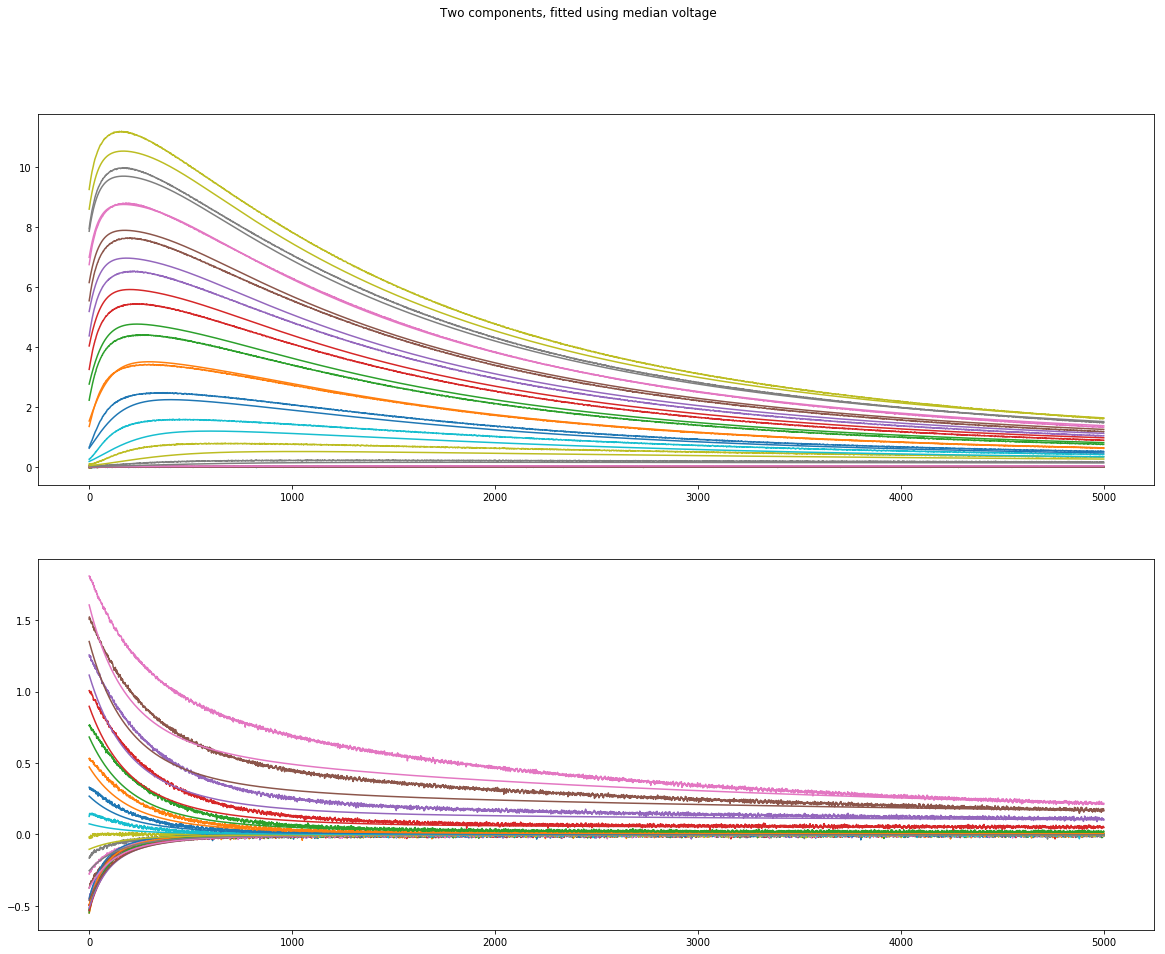

In [21]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
for I in Irec_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I1:
    plt.plot(I)

plt.subplot(2,1,2)
for I in Irec2_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I2:
    plt.plot(I)
    
plt.suptitle("Two components, fitted using median voltage")

In [22]:
print ret.x
print ret.cost

[-7.66437870e+01  2.17870166e-02  9.14216355e-02]
1000.9606010330099


Not much worse than the achieved-voltage fit. Well, looks like my kinetics are no good after all. Let's try the single-component kinetics instead, to check I've not actually made things worse by adding that second component...

In [23]:
# rec preparation
rec_hold_state_single = zip(*Kv14.state_at_single(10000, Vhold, (0,1)))

rec_states_single = np.zeros((len(a.rec.voltage), tmax, 2))
for i, voltage, state in zip(range(len(a.rec.voltage)), a.rec.voltage, rec_hold_state_single):
    for t in range(tblank):
        V = voltage[Kv14.rec_step_t0 + t]
        state = Kv14.state_at_single(Kv14.tres, V, state)

    for t in range(tmax):
        V = voltage[Kv14.rec_limits[0] + t]
        state = Kv14.state_at_single(Kv14.tres, V, state)
        rec_states_single[i][t] = state

In [24]:
# rec2 preparation
rec2_hold_state_single = zip(*Kv14.state_at_single(10000, Vhold2, (0,1)))

rec2_states_single = np.zeros((len(a.rec2.voltage), t2max, 2))
for i, voltage, state in zip(range(len(a.rec2.voltage)), a.rec2.voltage, rec2_hold_state_single):
    for t in range(Kv14.rec2_prepulse, Kv14.rec2_limits[0]):
        state = Kv14.state_at_single(Kv14.tres, voltage[t], state)

    for t in range(t2blank):
        V = voltage[Kv14.rec2_limits[0] + t]
        state = Kv14.state_at_single(Kv14.tres, V, state)

    for t in range(t2max):
        V = voltage[a.rec2.tail_cut + t]
        state = Kv14.state_at_single(Kv14.tres, V, state)
        rec2_states_single[i][t] = state

In [25]:
def currents_single(ps):
    Irec = np.reshape([(voltage[Kv14.rec_limits[0] + t] - ps[0]) * (ps[1] * state[0]**4 * state[1])
                      for voltage, states in zip(a.rec.voltage, rec_states_single)
                      for t, state in enumerate(states)],
                     (len(a.rec.voltage), tmax))

    Irec2 = np.reshape([(voltage[a.rec2.tail_cut + t] - ps[0]) * (ps[1] * state[0]**4 * state[1])
                       for voltage, states in zip(a.rec2.voltage, rec2_states_single)
                       for t, state in enumerate(states)],
                      (len(a.rec2.voltage), t2max))
    
    return (Irec, Irec2)

In [26]:
start = time.time()
ret = scipy.optimize.least_squares(residuals, ps, args = (currents_single,), bounds = ([-100, 0], [-50, 0.2]))
print time.time() - start

5.248016119


In [27]:
I1, I2 = currents_single(ret.x)

Text(0.5,0.98,'Single component, fitted using achieved voltage')

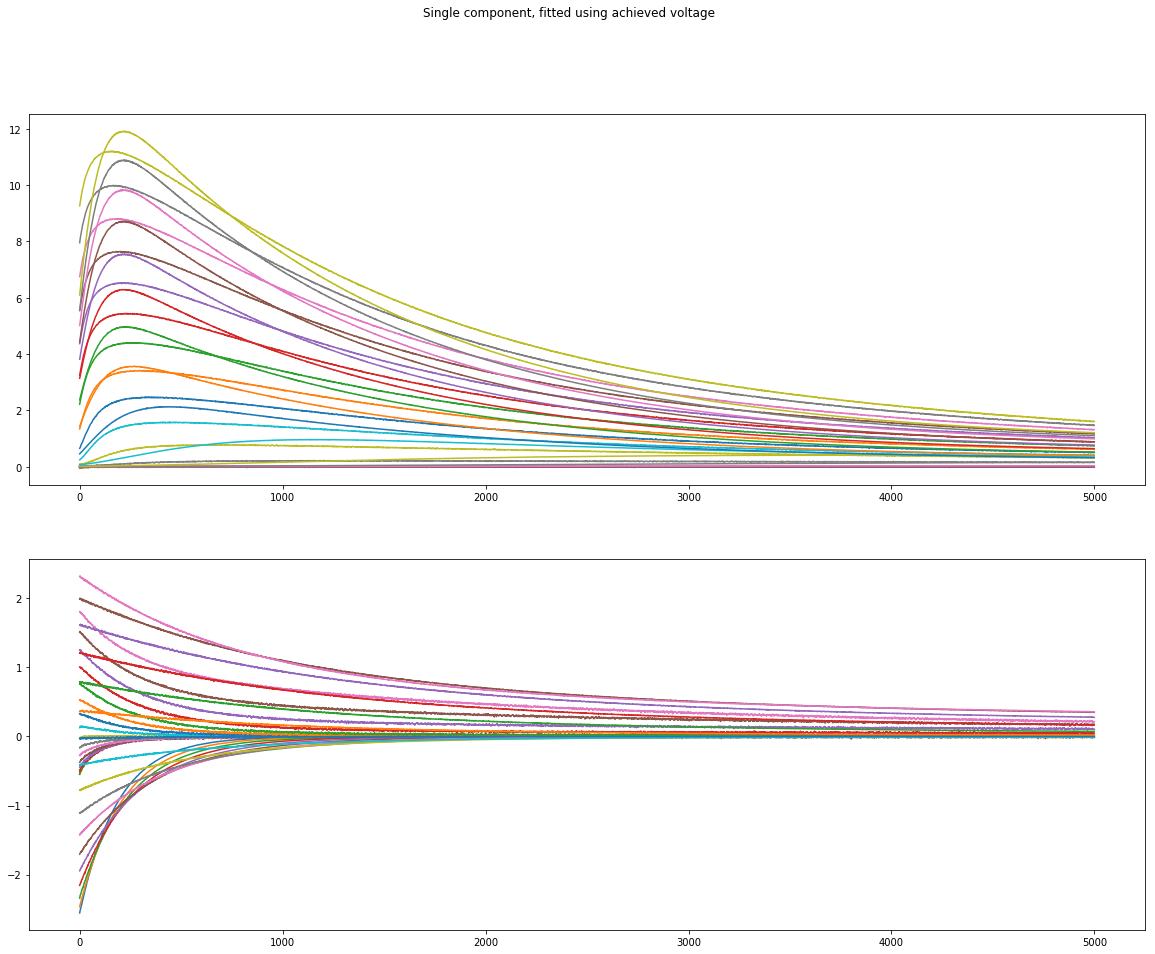

In [28]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
for I in Irec_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I1:
    plt.plot(I)

plt.subplot(2,1,2)
for I in Irec2_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I2:
    plt.plot(I)

plt.suptitle("Single component, fitted using achieved voltage")

In [29]:
print ret.x
print ret.cost

[-69.45599125   0.12762237]
8165.063786553756


Whew, that's a bit of a relief. Then again, the single-component kinetics are literature values, and I'd certainly expect those to fit less nicely to my data.